# Stock Price Prediction: Model Training and Evaluation

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import talib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [140]:
# Load the preprocessed data
df = pd.read_csv('preprocessed_500033.csv', index_col='Date', parse_dates=True)

In [141]:
def preprocess_data(df):
    # Remove rows with NaN or infinity values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Create technical indicators
    df['RSI'] = talib.RSI(df['Close Price'], timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close Price'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['Close Price'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # Generate lagged features
    df['Lag_1_Close'] = df['Close Price'].shift(1)
    df['Lag_2_Close'] = df['Close Price'].shift(2)
    df['Lag_1_Volume'] = df['No.of Shares'].shift(1)
    df['Lag_2_Volume'] = df['No.of Shares'].shift(2)

    # Calculate returns
    df['Daily_Return'] = df['Close Price'].pct_change()

    # Drop NaN values created by the shift operations
    df.dropna(inplace=True)

    return df

In [142]:
# Use this function before splitting the data
df = preprocess_data(df)

In [143]:
# Use the selected features
selected_features = ['upper_band', 'Open Price', 'High Price', 'lower_band', 'WAP', 'Lag_1_Close', 'middle_band', 'Lag_2_Close', 'Low Price']
X = df[selected_features]
y = df['Close Price']

In [144]:
# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [145]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [146]:
# Model evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    return rmse, mape

In [147]:
# XGBoost model
def train_xgboost(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return evaluate_model(y_test, predictions, "XGBoost")

In [148]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

def train_lstm(X_train, y_train, X_test, y_test):
    X_train, y_train = create_sequences(X_train, y_train)
    X_test, y_test = create_sequences(X_test, y_test)
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    inputs = Input(shape=input_shape)
    x = LSTM(50, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    predictions = model.predict(X_test).flatten()
    return evaluate_model(y_test, predictions, "LSTM")

In [149]:
def train_arima(train, test):
    # Ensure train and test have a DatetimeIndex
    train = pd.Series(train.values, index=pd.date_range(start=train.index[0], periods=len(train), freq='D'))
    test = pd.Series(test.values, index=pd.date_range(start=test.index[0], periods=len(test), freq='D'))
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(train)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    # Use auto_arima to find the best parameters
    model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                       start_P=0, seasonal=False, d=1, D=1, trace=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True)
    
    # Fit the ARIMA model
    model_fit = model.fit(train)
    
    # Make predictions
    predictions = model_fit.predict(n_periods=len(test), index=test.index)
    return evaluate_model(test, predictions, "ARIMA")

In [150]:
def train_hybrid(X_train, y_train, X_test, y_test):
    # Ensure y_train and y_test have a DatetimeIndex
    y_train = pd.Series(y_train.values, index=pd.date_range(start=y_train.index[0], periods=len(y_train), freq='D'))
    y_test = pd.Series(y_test.values, index=pd.date_range(start=y_test.index[0], periods=len(y_test), freq='D'))
    
    # ARIMA component
    try:
        arima_model = auto_arima(y_train, start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                                 start_P=0, seasonal=False, d=1, D=1, trace=True,
                                 error_action='ignore', suppress_warnings=True, stepwise=True)
        arima_model_fit = arima_model.fit(y_train)
        arima_predictions = arima_model_fit.predict(n_periods=len(y_test), index=y_test.index)
    except Exception as e:
        print(f"ARIMA model failed: {e}")
        arima_predictions = np.zeros(len(y_test))
    
    # XGBoost component
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_model.fit(X_train, y_train - arima_model_fit.predict(n_periods=len(y_train), index=y_train.index))
    xgb_predictions = xgb_model.predict(X_test)
    
    # Combine predictions
    hybrid_predictions = arima_predictions + xgb_predictions
    return evaluate_model(y_test, hybrid_predictions, "ARIMA + XGBoost")

In [151]:
def train_models(X_train, y_train, X_test, y_test):
    results = {}
    
    try:
        results['XGBoost'] = train_xgboost(X_train, y_train, X_test, y_test)
    except Exception as e:
        print(f"XGBoost training failed: {e}")
    
    try:
        results['LSTM'] = train_lstm(X_train, y_train, X_test, y_test)
    except Exception as e:
        print(f"LSTM training failed: {e}")
    
    try:
        results['ARIMA'] = train_arima(y_train, y_test)
    except Exception as e:
        print(f"ARIMA training failed: {e}")
    
    try:
        results['Hybrid'] = train_hybrid(X_train, y_train, X_test, y_test)
    except Exception as e:
        print(f"Hybrid model training failed: {e}")
    
    return results

In [152]:
# Initialize lists to store results
all_results = []

In [153]:
# Perform cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and evaluate models
    results = train_models(X_train_scaled, y_train, X_test_scaled, y_test)
    all_results.append(results)

XGBoost - RMSE: 62.97, MAPE: 3.65%
LSTM training failed: 'numpy.ndarray' object has no attribute 'iloc'
ADF Statistic: -1.3774396825647435
p-value: 0.5930427649972415
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3885.004, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3882.321, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3883.261, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3883.316, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3880.375, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.105 seconds
ARIMA - RMSE: 430.59, MAPE: 37.60%
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3885.004, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3882.321, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3883.261, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3883.316, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC

In [154]:
# Aggregate results
avg_results = {}
for model in ['XGBoost', 'LSTM', 'ARIMA', 'Hybrid']:
    model_results = [fold[model] for fold in all_results if model in fold]
    if model_results:
        avg_rmse = np.mean([result[0] for result in model_results])
        avg_mape = np.mean([result[1] for result in model_results])
        avg_results[model] = (avg_rmse, avg_mape)

In [155]:
# Print average results
print("\nAverage Results:")
for model, (rmse, mape) in avg_results.items(): 
    print(f"{model} - Avg RMSE: {rmse:.2f}, Avg MAPE: {mape:.2%}")


Average Results:
XGBoost - Avg RMSE: 376.77, Avg MAPE: 18.16%
ARIMA - Avg RMSE: 1009.94, Avg MAPE: 74.36%


<Figure size 1200x600 with 0 Axes>

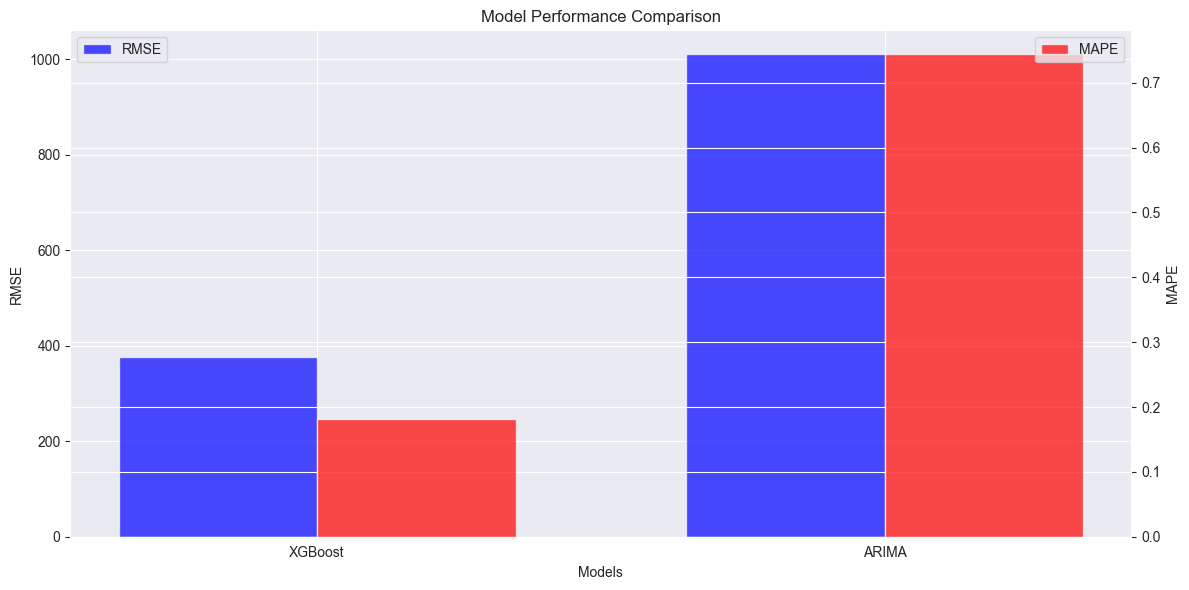

In [157]:
# Visualize results
plt.figure(figsize=(12, 6))
models = list(avg_results.keys())
rmse_values = [avg_results[model][0] for model in models]
mape_values = [avg_results[model][1] for model in models]

x = range(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

rects1 = ax1.bar([i - width/2 for i in x], rmse_values, width, label='RMSE', color='b', alpha=0.7)
rects2 = ax2.bar([i + width/2 for i in x], mape_values, width, label='MAPE', color='r', alpha=0.7)

ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('MAPE')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()